{'PoolQC': 1453, 'FireplaceQu': 690, 'GarageCond': 81, 'MasVnrType': 8, 'BsmtCond': 37, 'LotFrontage': 259, 'GarageQual': 81, 'BsmtFinType1': 37, 'Electrical': 1, 'GarageType': 81, 'BsmtQual': 37, 'BsmtExposure': 38, 'GarageFinish': 81, 'MiscFeature': 1406, 'Alley': 1369, 'GarageYrBlt': 81, 'MasVnrArea': 8, 'BsmtFinType2': 38, 'Fence': 1179}


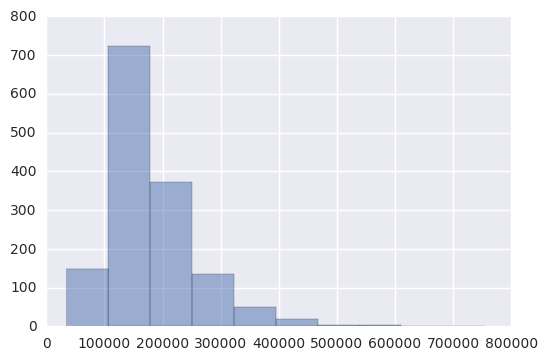

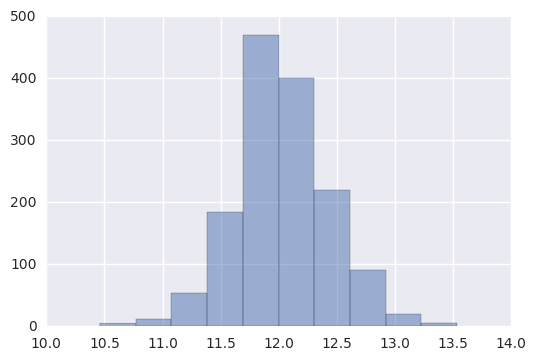

In [102]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
from __future__ import division

#Loading the training and the test data
Train_df = pd.read_csv('C:/Users/Mash/Desktop/Kaggle/Regression_house_prices/train.csv')
Test_df = pd.read_csv('C:/Users/Mash/Desktop/Kaggle/Regression_house_prices/test.csv')

#print (Train_df.columns)
#print (Train_df.describe())

# No of columns in the df
#print (Train_df.info())

#Segregating Quantitative and Qualitative columns
quantitative = [f for f in Train_df.columns if Train_df.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in Train_df.columns if Train_df.dtypes[f] == 'object']

# checking the columns with NaN values
NaN_columns = {}
for i in Train_df.columns:
    if pd.isnull(Train_df[i]).sum() >0:
        NaN_columns[i] = pd.isnull(Train_df[i]).sum()
print (NaN_columns)

#Analysing the sale price normality and applying log transformation since the original values are right skewed
plt.hist(Train_df['SalePrice'], alpha = 0.5)
plt.show()
y =np.log(Train_df['SalePrice'])
plt.hist(y,alpha = 0.5)
plt.show()



C:\Users\Mash\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


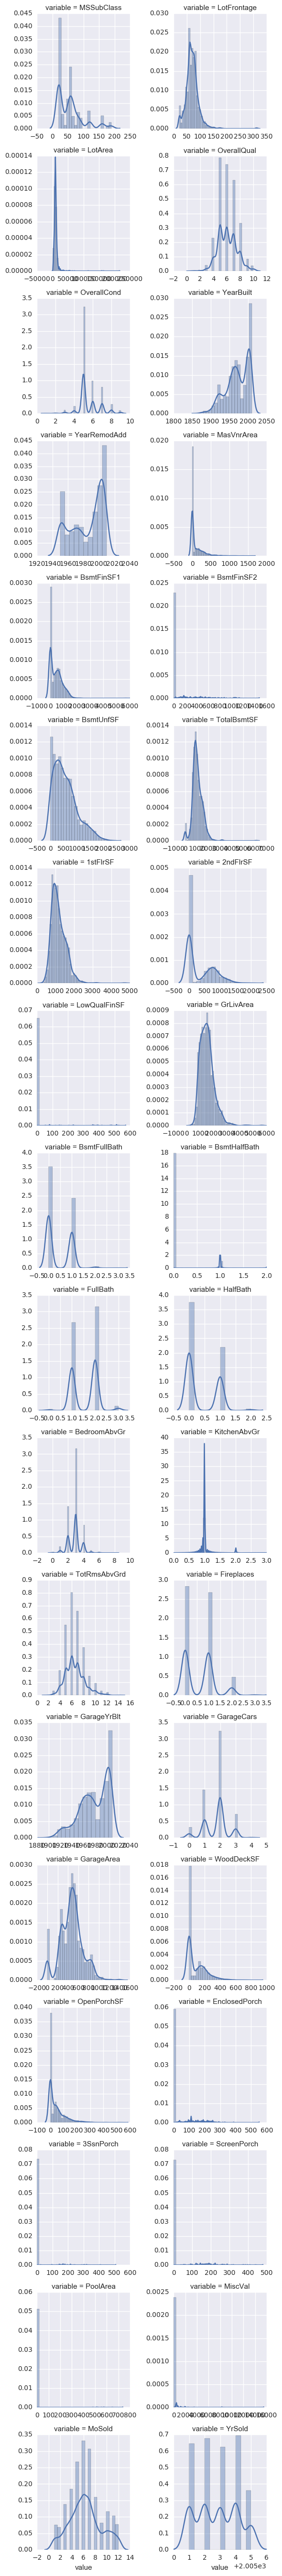

In [66]:
# Checking the distribution of all quantitative varibles
f = pd.melt(Train_df, value_vars=quantitative)
graph  = sns.FacetGrid(f,col = "variable",col_wrap=2,sharex=False, sharey=False)
graph = graph.map(sns.distplot, "value")

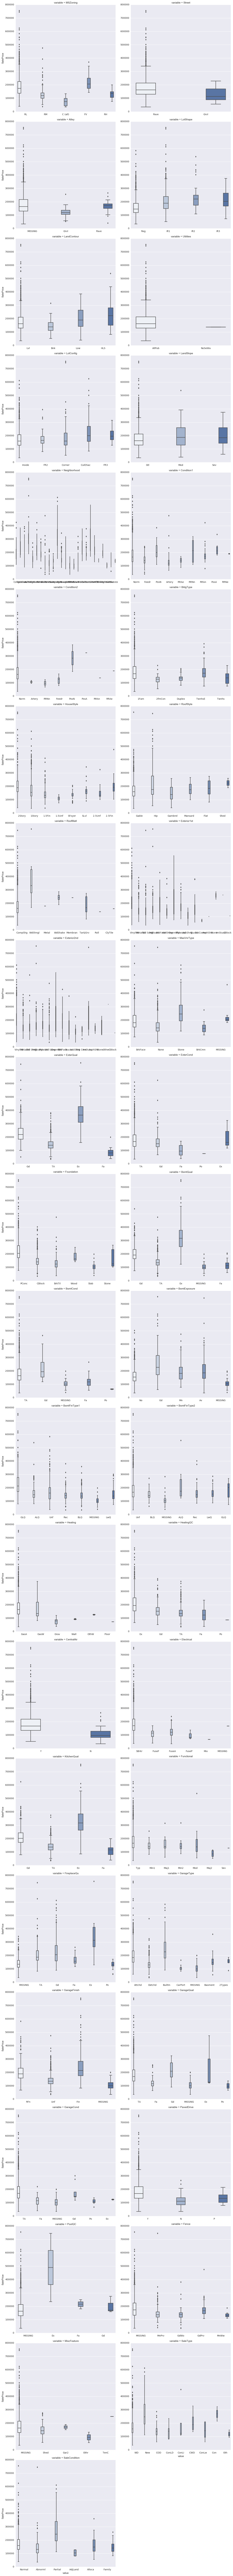

In [67]:
# Checking the Quanlitative variable and adding a category MISSING if Nan is present

for i in qualitative:
    if Train_df[i].isnull().any():
        Train_df[i]=Train_df[i].fillna('MISSING')

#Using box plots to plot categorical data along with sale price
f = pd.melt(Train_df ,value_vars = qualitative, id_vars='SalePrice')
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=7)
g = g.map(sns.boxplot,'value','SalePrice',"value")


(43, 2)
(27, 2)


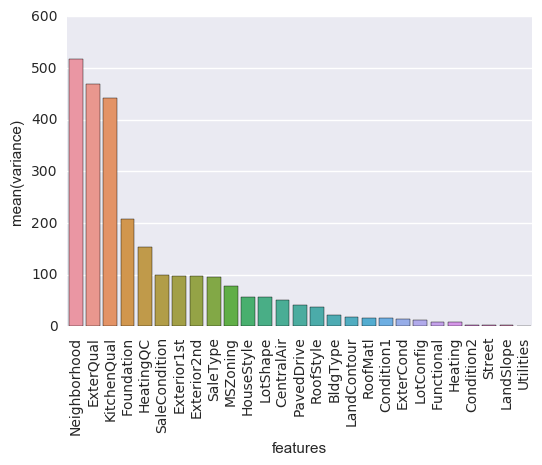

In [107]:
#Grouping the categorical variables to check the ANOVA
#If the P value is less among them ,then they have low impact on the sale price else high impact

def anova(train):
    anova_df = pd.DataFrame({'features':qualitative})
    pvals = []
    for i in qualitative:
        values =[]
        for j in train[i].unique():
            SP = train[train[i]==j]['SalePrice'].values
            values.append(SP)
        #print (*values)
        pval = stats.f_oneway(*values)[1]
        pvals.append(pval)
    anova_df['pvals'] = pvals
    return anova_df.sort_values('pvals')        
a = anova(Train_df)
print (a.shape)
a = a[a.pvals.notnull()]
print (a.shape)
a['variance'] = np.log(1/a['pvals'].values)
sns.barplot(data = a, x = 'features', y = 'variance')
x=plt.xticks(rotation=90) #[ for making the features visible]

In [122]:
# from the above only the variables with non null P value to be considered for further operations
qualitative_reduced =a.features
print (qualitative_reduced)

8      Neighborhood
18        ExterQual
30      KitchenQual
20       Foundation
27        HeatingQC
42    SaleCondition
15      Exterior1st
16      Exterior2nd
41         SaleType
0          MSZoning
12       HouseStyle
3          LotShape
28       CentralAir
37       PavedDrive
13        RoofStyle
11         BldgType
4       LandContour
14         RoofMatl
9        Condition1
19        ExterCond
6         LotConfig
31       Functional
26          Heating
10       Condition2
1            Street
7         LandSlope
5         Utilities
Name: features, dtype: object


In [123]:
#categorical variable encoding (target  based for regression)
# http://www.saedsayad.com/encoding.htm - refer example 2
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    #print (ordering.spmean)
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o
    
qual_encoded = []
for q in qualitative_reduced:  
    encode(Train_df, q)
    qual_encoded.append(q+'_E')
print(qual_encoded)


['Neighborhood_E', 'ExterQual_E', 'KitchenQual_E', 'Foundation_E', 'HeatingQC_E', 'SaleCondition_E', 'Exterior1st_E', 'Exterior2nd_E', 'SaleType_E', 'MSZoning_E', 'HouseStyle_E', 'LotShape_E', 'CentralAir_E', 'PavedDrive_E', 'RoofStyle_E', 'BldgType_E', 'LandContour_E', 'RoofMatl_E', 'Condition1_E', 'ExterCond_E', 'LotConfig_E', 'Functional_E', 'Heating_E', 'Condition2_E', 'Street_E', 'LandSlope_E', 'Utilities_E']


           features  sp_coeff
29    EnclosedPorch -0.218394
21     KitchenAbvGr -0.164826
4       OverallCond -0.129325
14     LowQualFinSF -0.067719
33          MiscVal -0.062727
9        BsmtFinSF2 -0.038806
35           YrSold -0.029899
17     BsmtHalfBath -0.012189
0        MSSubClass  0.007192
62      Utilities_E  0.016710
60         Street_E  0.045814
61      LandSlope_E  0.050310
32         PoolArea  0.058453
30        3SsnPorch  0.065440
34           MoSold  0.069432
53       RoofMatl_E  0.090497
31      ScreenPorch  0.100070
56      LotConfig_E  0.105029
59     Condition2_E  0.107173
58        Heating_E  0.121949
55      ExterCond_E  0.130370
57     Functional_E  0.136477
51       BldgType_E  0.151785
52    LandContour_E  0.154423
50      RoofStyle_E  0.163782
10        BsmtUnfSF  0.185197
54     Condition1_E  0.202877
16     BsmtFullBath  0.225125
20     BedroomAbvGr  0.234907
49     PavedDrive_E  0.280602
..              ...       ...
48     CentralAir_E  0.313286
41  SaleCo

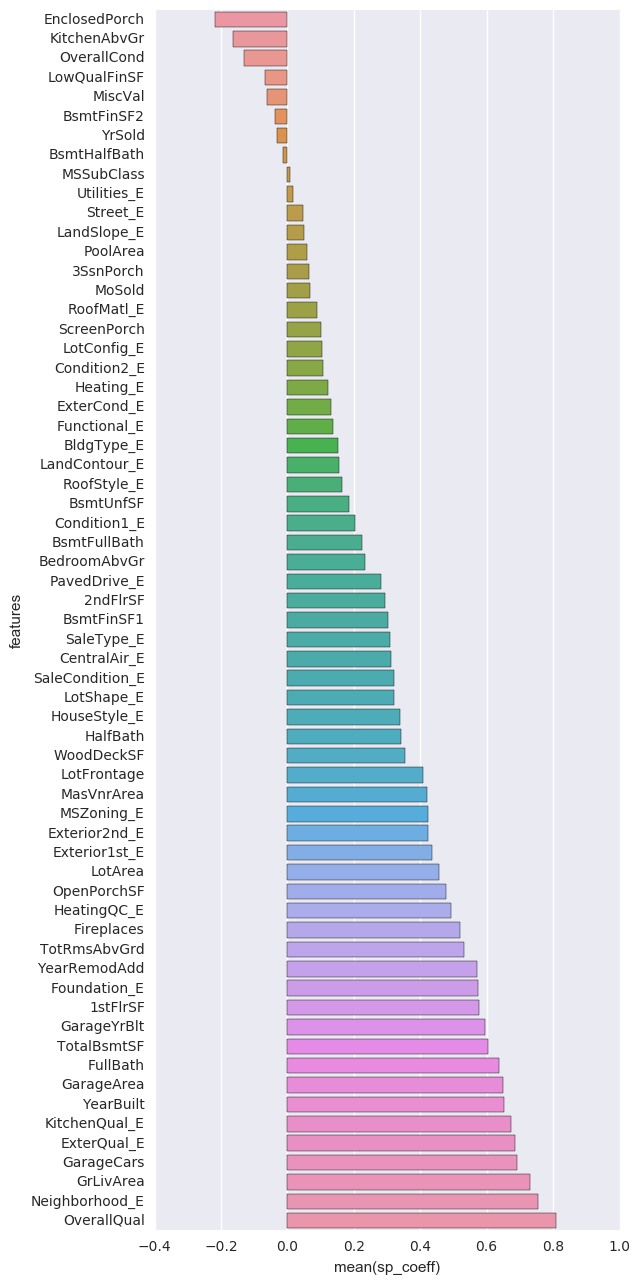

In [134]:
#Checking the Corelation of variables using spearmans coefficient
combo_features = quantitative + qual_encoded
spr = pd.DataFrame({'features':combo_features})
spr['sp_coeff'] = [Train_df[f].corr(Train_df['SalePrice'],'spearman') for f in combo_features]
spr = spr.sort_values('sp_coeff')
plt.figure(figsize=(6, 0.25*len(combo_features)))
sns.barplot(data=spr, y='features', x='sp_coeff', orient='h')

In [155]:
# choosing features which have a co-relation over 0.2
filtered_features = spr[spr.sp_coeff>0.2].features
# number of significant features = 37
f_quant = []
f_qual = []
for i in filtered_features:
    if i in quantitative:
        f_quant.append(i)
    else:
        f_qual.append(i)
print (f_quant)
print (f_qual)

['BsmtFullBath', 'BedroomAbvGr', '2ndFlrSF', 'BsmtFinSF1', 'HalfBath', 'WoodDeckSF', 'LotFrontage', 'MasVnrArea', 'LotArea', 'OpenPorchSF', 'Fireplaces', 'TotRmsAbvGrd', 'YearRemodAdd', '1stFlrSF', 'GarageYrBlt', 'TotalBsmtSF', 'FullBath', 'GarageArea', 'YearBuilt', 'GarageCars', 'GrLivArea', 'OverallQual']
['Condition1_E', 'PavedDrive_E', 'SaleType_E', 'CentralAir_E', 'SaleCondition_E', 'LotShape_E', 'HouseStyle_E', 'MSZoning_E', 'Exterior2nd_E', 'Exterior1st_E', 'HeatingQC_E', 'Foundation_E', 'KitchenQual_E', 'ExterQual_E', 'Neighborhood_E']
